In [1]:
import numpy as np
import matplotlib.pyplot as plt
from create_gaussian_curves import *
np.random.seed(42)

## Simulations

We generate $N$ Gaussian curves using
$$\mu_i \sim \mathcal{N}(\mu_x;\sigma^2_x)\quad\text{and}\quad \sigma_i \sim \Gamma(a_x, b_x), \quad i=1,\ldots,N $$
and we vectorize the curves in the range [`xmin`-`xmax`] in `nbx` points.

In [2]:
# Fix simulation parameters values
mux, sdx = 0., 1.
ax, bx   = 7.0, 0.2
N        = 3000
xmin, xmax, nbx = -6, 6, 400
sd_noise = 0.

In [3]:
# Generate the values mu_i, sigma_i, i=1,...,N
mu = np.random.normal(loc=mux, scale=sdx, size=N)
sd = np.random.gamma(shape=ax, scale=bx, size=N)

In [4]:
x, Y = create_gaussian_curves(mu, sd, N, xmin, xmax, nbx, sd_noise)
x.shape, Y.shape

((400,), (3000, 400))

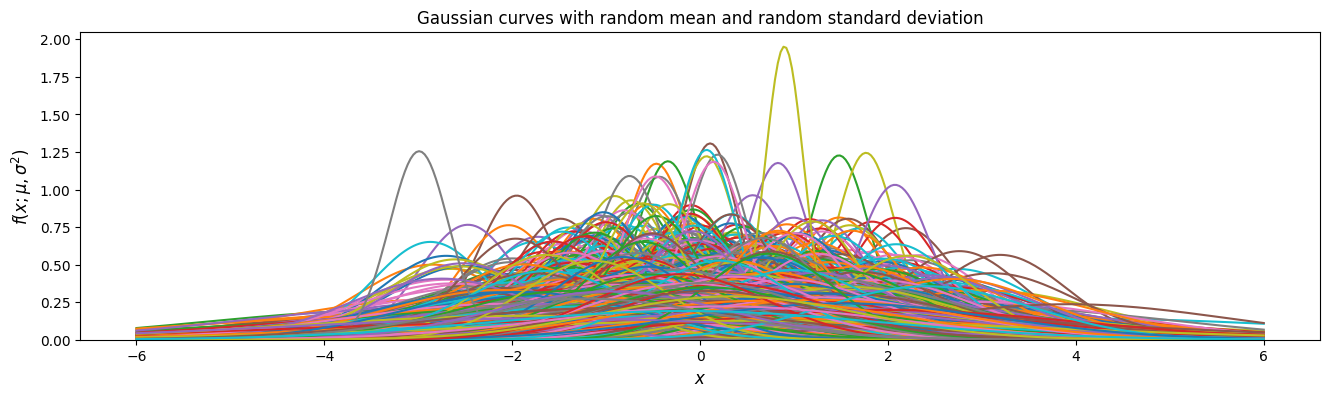

In [5]:
# plot the result
ymax = np.max(Y)

fix, ax = plt.subplots(figsize=(16,4))

for i in range(N):
    ax.plot(x, Y[i,:])

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$f(x; \\mu, \\sigma^2)$', fontsize=12)
ax.set_ylim(0, ymax+0.1)
ax.set_title("Gaussian curves with random mean and random standard deviation")

plt.show()

## PCA of the curves

Gaussian curves aren't truly
`nbx`-dimensional; they're parameterized by just two numbers:
the mean $\mu$ and the standard deviation $\sigma$.

Principal Component
Analysis (PCA) will help us discover this intrinsic low-dimensional structure.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from analyze_pca import *

In [7]:
max_components = 20  # Limit to 20 components

In [8]:
# Perform PCA analysis (see file analyze_pca.py)
Z, mse_errors, explained_variance, pca_model, pca_scaler = analyze_pca(Y, max_components)
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

In [9]:
component_counts = [2, 4, 8, 12, 16, 20]

### First plots

- Evolution of the MSE between the **true** curves and the **reconstructed** curves
$$ MSE(d) = \frac{1}{N} \|Y_i - Y_i^{\text{rec}}\|^2 $$
  The MSE will decrease with $d$, where $d$ is the number of components. If $d=nbx$ then MSE is 0.
- Evolution of the ratio of the explained variance. if $d=nbx$ then the ratio is 1.

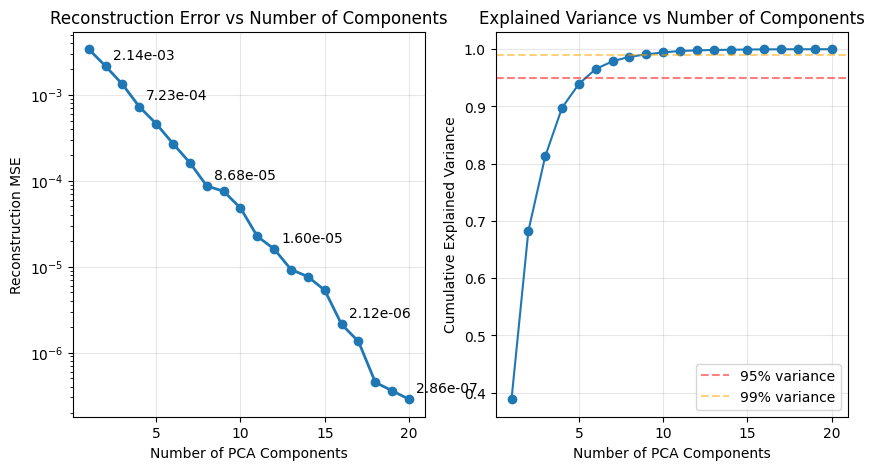

In [10]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot reconstruction error (MSE) vs number of components
axes[0].plot(range(1, len(mse_errors) + 1), mse_errors, marker='o', linewidth=2)
axes[0].set_xlabel('Number of PCA Components')
axes[0].set_ylabel('Reconstruction MSE')
axes[0].set_title('Reconstruction Error vs Number of Components')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')  # Use log scale for better visualization

# Add annotations for specific component counts
for n_comp in component_counts:
    idx = n_comp - 1
    axes[0].annotate(f'{mse_errors[idx]:.2e}', xy=(n_comp, mse_errors[idx]),
                       xytext=(5, 5), textcoords='offset points')

# Plot cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
axes[1].axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% variance')
axes[1].axhline(y=0.99, color='orange', linestyle='--', alpha=0.5, label='99% variance')
axes[1].set_xlabel('Number of PCA Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Explained Variance vs Number of Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

### Second plot

Pick randomly 3 curves and compare visualy the reconstructed curves with the original curves.

As the number of components $d$ increases, the reconstructed curves become closer to the true curve.


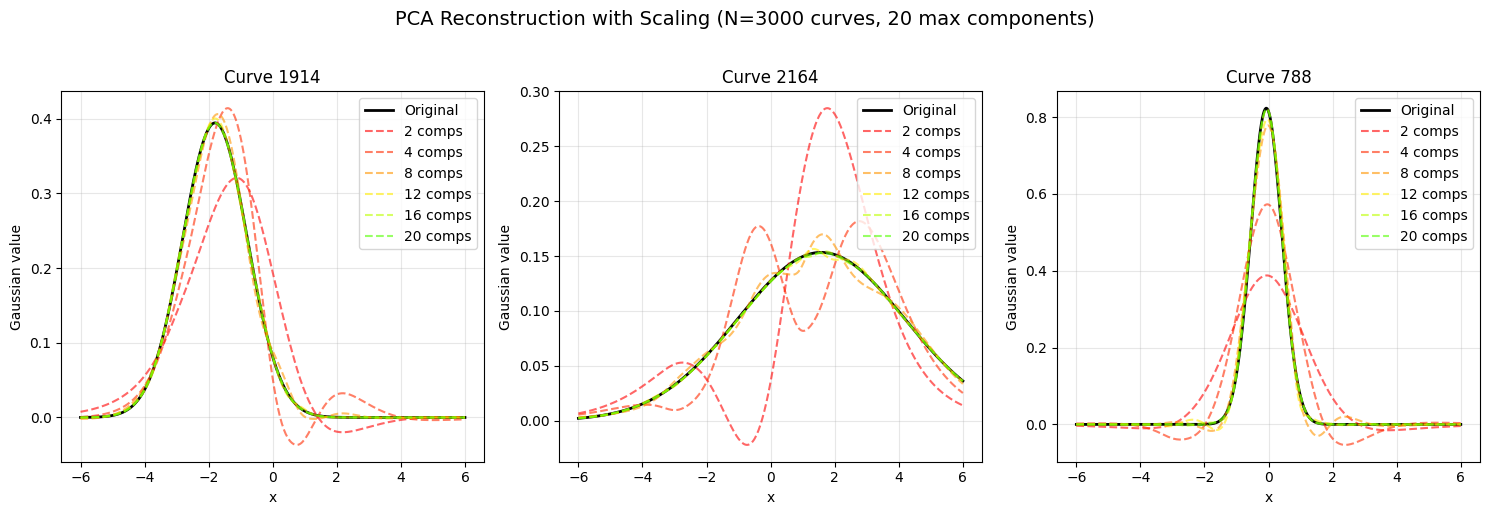

In [11]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot example reconstructions for different numbers of components
curve_idx = np.random.randint(0, N, size=3)  # Pick randomly 3 curves
colors   = plt.cm.prism(np.linspace(0, 1, len(component_counts)))

for col, idx in enumerate(curve_idx):
    curve = Y[idx]
    
    # true curve    
    axes[col].plot(x, curve, 'k-', linewidth=2, label='Original')
    # Reconstruct using different numbers of components
    for color_idx, n_comp in enumerate(component_counts):
        # Use the helper function
        curve_rec = build_reconstructed_curve(curve, n_comp, pca_model, pca_scaler)
        # Plot the reconstruction
        axes[col].plot(x, curve_rec, '--', alpha=0.6, color=colors[color_idx], label=f'{n_comp} comps')
    axes[col].set_xlabel('x')
    axes[col].set_ylabel('Gaussian value')
    axes[col].set_title(f'Curve {idx}')
    axes[col].legend(loc='upper right')
    axes[col].grid(True, alpha=0.3)

# Add a main title
fig.suptitle(f'PCA Reconstruction with Scaling (N={N} curves, {max_components} max components)', 
             fontsize=14, y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

### Third plot

Plot the first 3 principal components.

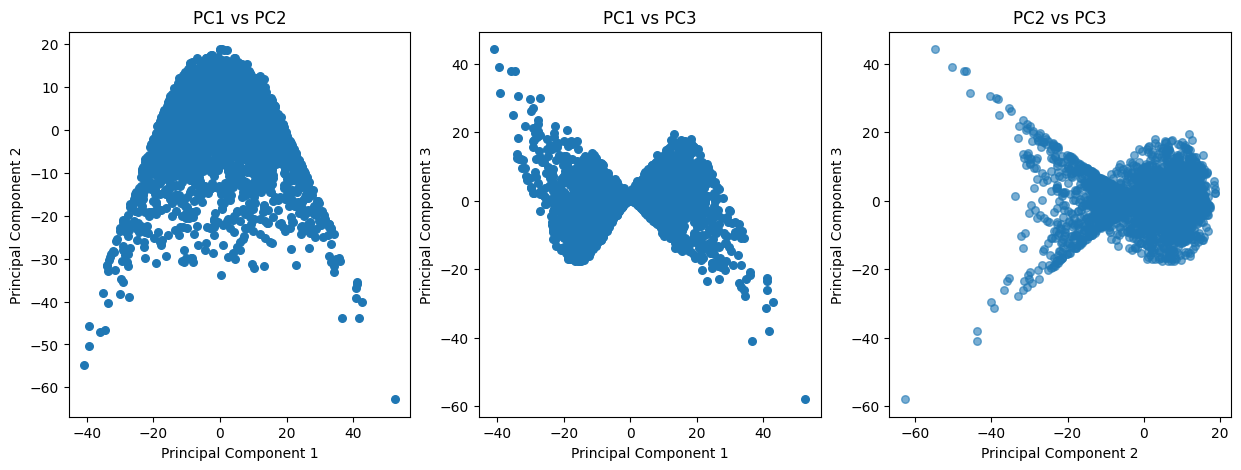

In [12]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))

# Plot PC1 vs PC2
ax1 = axes[0]
scatter1 = ax1.scatter(Z[:, 0], Z[:, 1], s=30)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PC1 vs PC2')

# Plot PC1 vs PC3
ax2 = axes[1]
scatter2 = ax2.scatter(Z[:, 0], Z[:, 2], s=30)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 3')
ax2.set_title('PC1 vs PC3')

# Plot PC2 vs PC3
ax3 = axes[2]
scatter3 = ax3.scatter(Z[:, 1], Z[:, 2], alpha=0.6, s=30)
ax3.set_xlabel('Principal Component 2')
ax3.set_ylabel('Principal Component 3')
ax3.set_title('PC2 vs PC3')

plt.show()

## Gaussian Mixture Model (GMM) Clustering

In this section implements the following steps:

- Cluster the first $d$ principal components using Gaussian Mixture Models (GMM)
- Visualize the results
- Sample new component values from the learned GMM


#### Generate principal components

In [13]:
n_comp = 10
n_clusters = 8

In [14]:
# generate data
Z, pca, scaler = compute_pca(Y, n_comp, scale_data=True)

### Clustering start here

In [15]:
from sklearn.mixture import GaussianMixture